In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# import seaborn as sns
# import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
from transformers import RobertaTokenizer, TFRobertaModel

In [3]:
df = pd.read_csv("..//efcamdat.csv")

In [4]:
df['cefr_numeric'].value_counts()

cefr_numeric
1    191663
2    129591
3     61506
4     18187
5      5115
Name: count, dtype: int64

In [5]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
df.columns

Index(['writing_id', 'learner_id', 'learner_id_categorical', 'nationality',
       'l1', 'cefr', 'cefr_numeric', 'level', 'unit', 'topic_id_original',
       'topic_id_original_categorical', 'topic_id', 'topic_id_categorical',
       'text_number_per_learner_in_task', 'topic', 'secondary_topic',
       'topic_to_keep', 'date', 'time', 'grade', 'wordcount', 'mtld', 'text',
       'text_corrected'],
      dtype='object')

In [7]:
df.shape[0]

406062

In [8]:
text = df['text']
labels = df['cefr_numeric']

In [9]:
(train_texts, test_texts, train_labels, test_labels) = train_test_split(text, labels, test_size=.1, shuffle=True)

In [10]:
len(test_texts)

40607

In [11]:
# valid_texts_s = train_texts.iloc[:1000]
# valid_labels_s = train_labels.iloc[:1000]
# train_texts_s = train_texts.iloc[1000:20000]
# train_labels_s = train_labels.iloc[1000:20000]
# test_texts_s = test_texts.iloc[:1000]
# test_labels_s = test_labels.iloc[:1000]

valid_texts = train_texts.loc[:40607]
valid_labels = train_labels.loc[:40607]
train_texts = train_texts.loc[40607:]
train_labels = train_labels.loc[40607:]

In [12]:
max_length = 50

In [13]:
rtokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [14]:
train_encodings = rtokenizer(list(train_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = rtokenizer(list(valid_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = rtokenizer(list(test_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [15]:
def create_roberta_model(model,
                         num_classes = 5,
                         dropout=0.3,
                         learning_rate=0.0001):
    """
    """
    model.trainable = False

    tf.keras.mixed_precision.set_global_policy('mixed_float16')

    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='input_ids_layer')
    #token_type_ids = tf.keras.layers.Input(shape=(300,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='attention_mask_layer')

    model_inputs = [input_ids, attention_mask]
    model_out = model(input_ids=input_ids, attention_mask=attention_mask)

    model_out = model_out.last_hidden_state

    conv = tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu')(model_out)
    conv = tf.keras.layers.MaxPooling1D(pool_size=2)(conv)
    conv = tf.keras.layers.Dropout(dropout)(conv)
    lstm = tf.keras.layers.LSTM(units=256, return_sequences=False, return_state=False)(conv)
    lstm = tf.keras.layers.Dropout(dropout)(lstm)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(lstm)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=0.1)
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

    classification_model.compile(optimizer=optimizer,
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [16]:
test_model2 = create_roberta_model(model=roberta_model, num_classes=5)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


In [17]:
test_model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids_layer (InputLayer)   [(None, None)]       0           []                               
                                                                                                  
 attention_mask_layer (InputLay  [(None, None)]      0           []                               
 er)                                                                                              
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids_layer[0][0]',        
 el)                            thPoolingAndCrossAt               'attention_mask_layer[0][0]']   
                                tentions(last_hidde                                           

In [18]:
dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": train_encodings.input_ids, "attention_mask_layer": train_encodings.attention_mask}, train_labels))
dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

vdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": valid_encodings.input_ids, "attention_mask_layer": valid_encodings.attention_mask}, valid_labels))
vdataset = vdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [19]:
import gc
from tensorflow.keras.backend import clear_session

# Clear session and free memory before starting the training
clear_session()
gc.collect()

26548

In [20]:
# test_model_history = test_model2.fit([train_encodings.input_ids, train_encodings.attention_mask],
#                                       train_labels,
#                                       validation_data=([valid_encodings.input_ids, valid_encodings.attention_mask],
#                                       valid_labels),
#                                       batch_size=32,
#                                       epochs=3)

test_model_history = test_model2.fit(dataset,
                                      validation_data=vdataset,
                                      epochs=1)

4443/4443 [==============================] - 887s 196ms/step - loss: nan - accuracy: 0.9013 - val_loss: nan - val_accuracy: 0.9455


In [21]:
t = ""
test = rtokenizer(t, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [51]:
np.argmax(test_model2.predict([test.input_ids, test.attention_mask]))

1/1 [==============================] - 0s 80ms/step


1

In [23]:
df.iloc[0]['cefr_numeric']

1

In [24]:
import transformers
print(transformers.__version__)

4.41.2


In [25]:
df['text'].apply(lambda x: len(x))

0          206
1          125
2          129
3          182
4          230
          ... 
406057     885
406058     935
406059    1014
406060     936
406061    1002
Name: text, Length: 406062, dtype: int64

In [22]:
tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": test_encodings.input_ids, "attention_mask_layer": test_encodings.attention_mask}, test_labels))
tdataset = tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [32]:
preds = test_model2.predict(tdataset)

  55/1269 [>.............................] - ETA: 1:31

KeyboardInterrupt: 

In [24]:
preds = tf.argmax(preds, axis=-1)

In [25]:
print(classification_report(test_labels, preds.numpy()))

              precision    recall  f1-score   support

           1       0.98      0.98      0.98     19223
           2       0.98      0.92      0.95     12856
           3       0.80      0.97      0.88      6128
           4       0.84      0.83      0.83      1841
           5       0.00      0.00      0.00       559

    accuracy                           0.94     40607
   macro avg       0.72      0.74      0.73     40607
weighted avg       0.93      0.94      0.94     40607



C:\Users\Danny Skahill\miniconda3\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Danny Skahill\miniconda3\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Danny Skahill\miniconda3\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [26]:
cm = tf.math.confusion_matrix(test_labels, preds)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

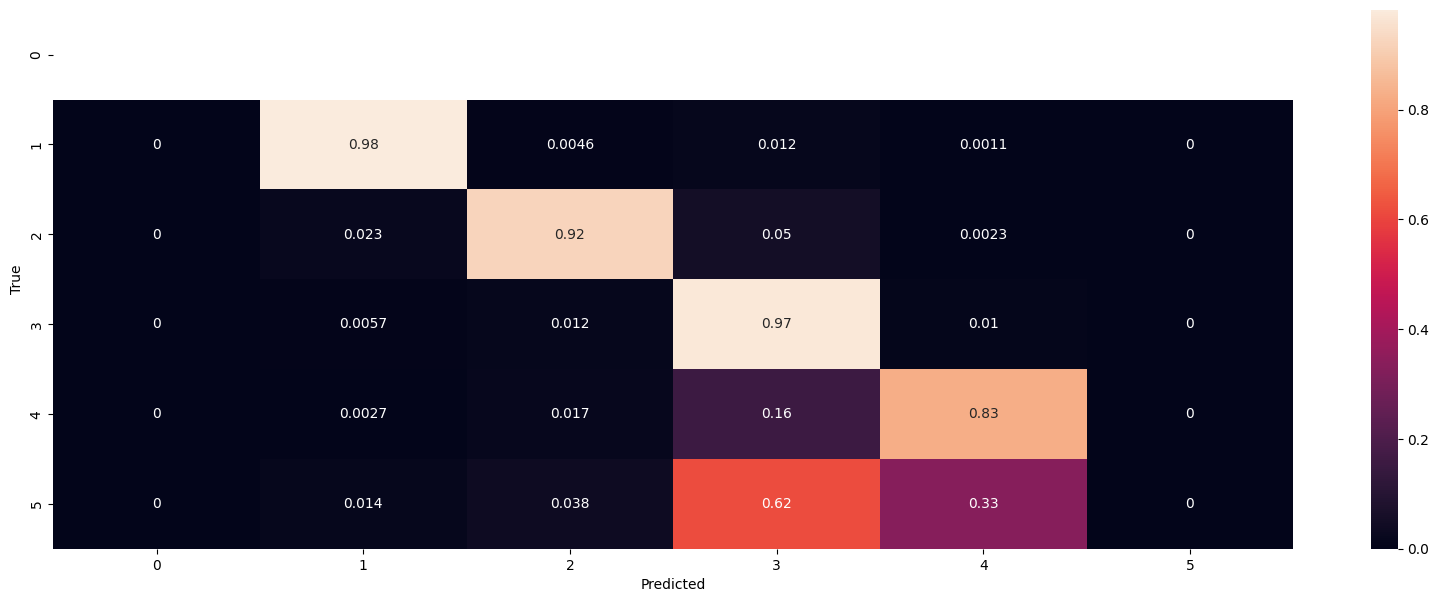

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

In [ ]:
# do a two tep for this model, balance the classes

In [86]:
def tokenized_len(t):
    return sum([1 for x in t if x != 1])

In [102]:
#[x for x in train_encodings['input_ids']]

for x in train_encodings.input_ids:
    print(tokenized_len(x)) 
    break

43
